# Packages:

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer
from keras.layers import Flatten
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras import callbacks

# Constants:

In [11]:
SEED = 42
DATA_DIR = "./Dataset/Images/"

np.random.seed(SEED)
tf.random.set_seed(SEED)

# Dataset:

Found 4600 images belonging to 2 classes.


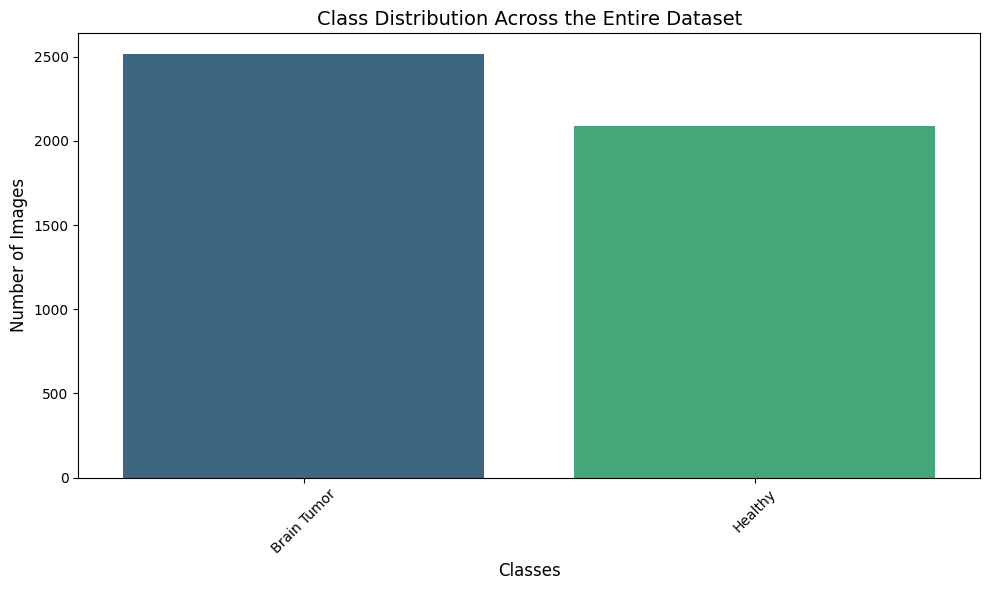

In [14]:
# Initialize ImageDataGenerator
image_data_generator = ImageDataGenerator(rescale=1.0 / 255, dtype=tf.float32)

# Load data from directory
data_gen = image_data_generator.flow_from_directory(DATA_DIR)

# Extract class labels and counts
class_labels = list(data_gen.class_indices.keys())
class_counts = data_gen.classes

# Create a DataFrame for class distribution
class_distribution = pd.DataFrame({"Class": [class_labels[i] for i in class_counts]})
class_distribution_counts = class_distribution.value_counts().reset_index(name="Count")
class_distribution_counts.columns = ["Class", "Count"]

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=class_distribution_counts, x="Class", y="Count", hue="Class", palette="viridis", dodge=False, legend=False)
plt.title("Class Distribution Across the Entire Dataset", fontsize=14)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
image_data_generator = ImageDataGenerator(rescale=1./255,
                                          validation_split = 0.2,
                                          zoom_range=(0.99, 0.99))

train = image_data_generator.flow_from_directory(
                               DATA_DIR,
                               target_size = (150, 150),
                               batch_size = 32,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = SEED,
                               subset = "training")


validation = image_data_generator.flow_from_directory(
                               DATA_DIR,
                               target_size = (150, 150),
                               batch_size = 32,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = SEED,
                               subset = "validation")

train.class_indices

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


{'Brain Tumor': 0, 'Healthy': 1}

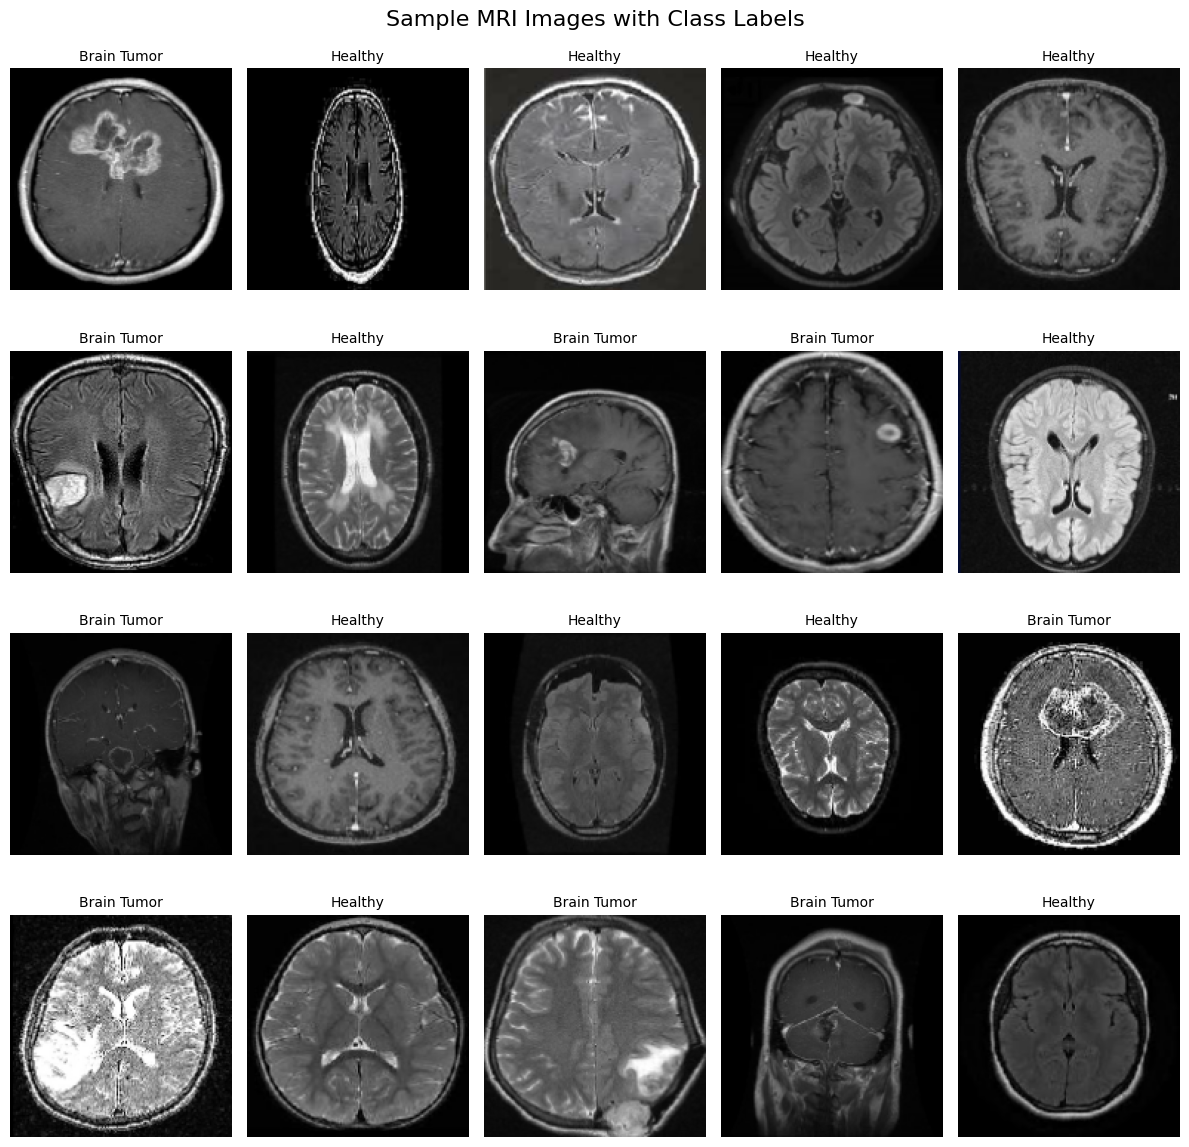

In [18]:
# Visualize sample images with labels
images, labels = next(train)

# Map labels to class names
label_names = [class_labels[int(label)] for label in labels]

# Create a grid of sample images
fig, axes = plt.subplots(4, 5, figsize=(12, 12))
fig.suptitle("Sample MRI Images with Class Labels", fontsize=16)
axes = axes.flatten()

for img, label, ax in zip(images, label_names, axes):
    ax.imshow(img)
    ax.set_title(label, fontsize=10)
    ax.axis("off")

# Turn off any unused subplots
for ax in axes[len(images):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

# Model:

In [19]:
def make_model(learning_rate=0.001, dropout_rate=0.3, size_inner=128):
    model = keras.Sequential()
    model.add(InputLayer(shape=(150, 150, 3)))
    model.add(Conv2D(filters=32, kernel_size=3, activation="relu", padding="same"))
    model.add(MaxPool2D())
    model.add(Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"))
    model.add(MaxPool2D())

    model.add(Flatten())

    model.add(Dense(size_inner, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(size_inner // 2, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss = BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

In [20]:
model = make_model(learning_rate=0.001, dropout_rate=0.3, size_inner=128)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,214,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,243,457 (42.89 MB)

 Trainable params: 11,243,073 (42.89 MB)

 Non-trainable params: 384 (1.50 KB)

# Initial Training:

In [22]:
early_stopping = callbacks.EarlyStopping(monitor="val_loss",
                                         mode="min",
                                         patience=5,
                                         restore_best_weights = True)

model = make_model(learning_rate=0.001, dropout_rate=0.3, size_inner=128)

history = model.fit(train,
                    verbose=1,
                    callbacks = [early_stopping],
                    epochs=20,
                    validation_data=validation)

Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.7056 - loss: 0.6016 - val_accuracy: 0.5517 - val_loss: 1.0435
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.8629 - loss: 0.3061 - val_accuracy: 0.9293 - val_loss: 0.1790
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.9500 - loss: 0.1546 - val_accuracy: 0.8041 - val_loss: 0.3984
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9664 - loss: 0.1061 - val_accuracy: 0.9369 - val_loss: 0.1754
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.9805 - loss: 0.0619 - val_accuracy: 0.9761 - val_loss: 0.0633
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 123ms/step - accuracy: 0.9850 - loss: 0.0446 - val_accuracy: 0.9826 - val_loss: 0.0702
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9839 - loss: 0.0461 - val_accuracy: 0.9412 - val_loss: 0.1458
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.9852 - loss: 0

In [23]:
# Plot model accuracy
def plot_model_accuracy(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Create a DataFrame for accuracy data
    accuracy_data = pd.DataFrame({
        "Epoch": epochs,
        "Accuracy": history.history['accuracy'],
        "Validation Accuracy": history.history['val_accuracy']
    })

    # Plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=accuracy_data, x="Epoch", y="Accuracy", marker="o", label="Accuracy", linewidth=2)
    sns.lineplot(data=accuracy_data, x="Epoch", y="Validation Accuracy", marker="o", label="Validation Accuracy", linewidth=2)

    plt.title("Model Accuracy", fontsize=16)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.ylim(0, 1)
    plt.legend(title="Metric")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Plot model loss
def plot_model_loss(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Create a DataFrame for loss data
    loss_data = pd.DataFrame({
        "Epoch": epochs,
        "Loss": history.history['loss'],
        "Validation Loss": history.history['val_loss']
    })

    # Plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=loss_data, x="Epoch", y="Loss", marker="o", label="Loss", linewidth=2)
    sns.lineplot(data=loss_data, x="Epoch", y="Validation Loss", marker="o", label="Validation Loss", linewidth=2)

    plt.title("Model Loss", fontsize=16)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])) * 1.1)
    plt.legend(title="Metric")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

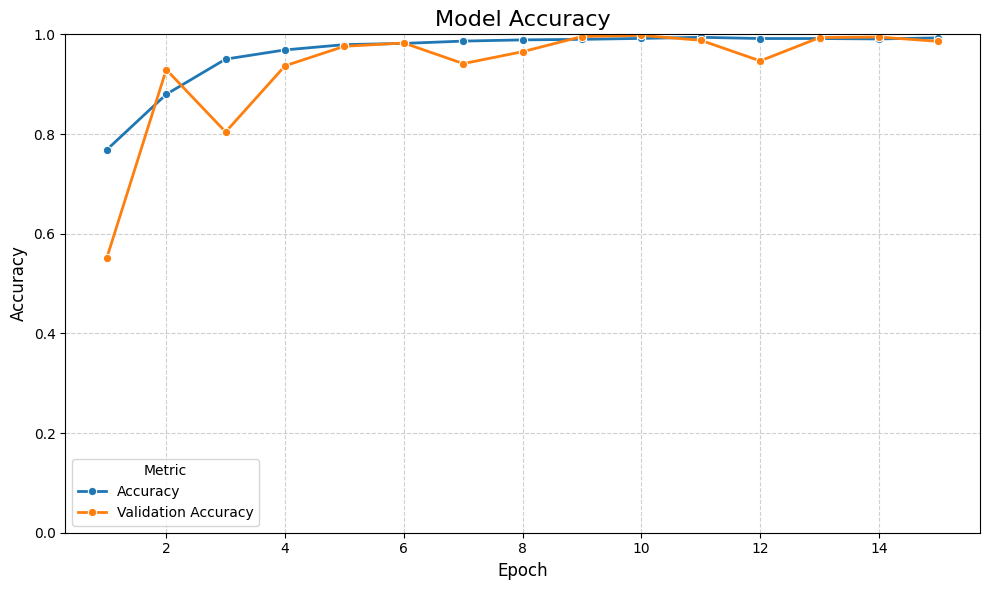

In [24]:
plot_model_accuracy(history)

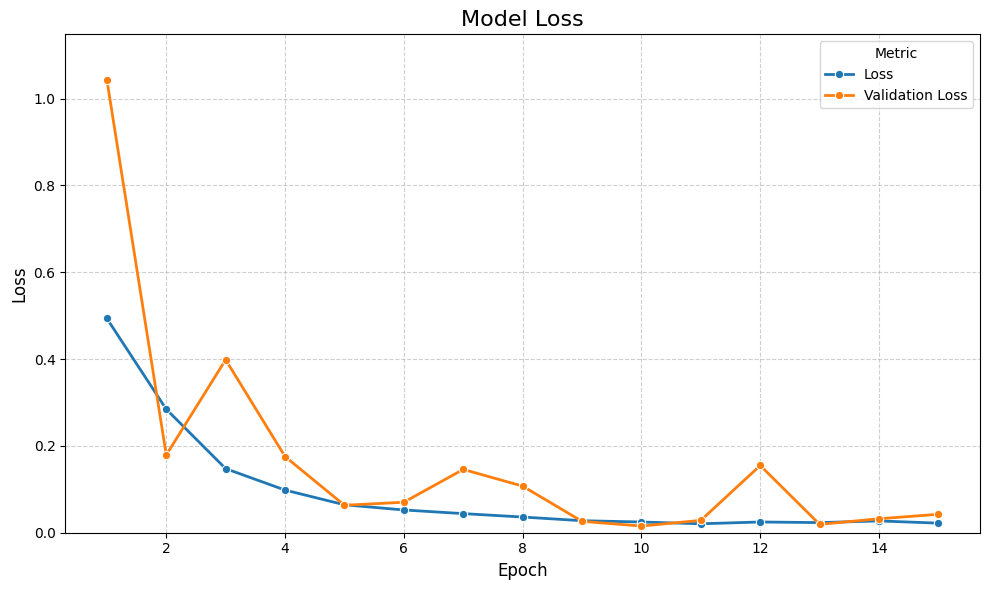

In [25]:
plot_model_loss(history)

# Model Tuning:

In [26]:
learning_rate_scores = {}

for learning_rate in [0.0001, 0.001, 0.01, 0.1]:
    print(learning_rate)

    model = make_model(learning_rate=learning_rate, dropout_rate=0.3, size_inner=128)
    history = model.fit(train,
                        verbose=1,
                        epochs=20,
                        validation_data=validation)
    learning_rate_scores[learning_rate] = history.history

    print()
    print()

0.0001
Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.7005 - loss: 0.6204 - val_accuracy: 0.8357 - val_loss: 0.4456
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.8879 - loss: 0.2939 - val_accuracy: 0.9140 - val_loss: 0.3563
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.9354 - loss: 0.1810 - val_accuracy: 0.9619 - val_loss: 0.1927
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - accuracy: 0.9704 - loss: 0.1084 - val_accuracy: 0.9576 - val_loss: 0.1643
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.9718 - loss: 0.0884 - val_accuracy: 0.9630 - val_loss: 0.1198
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9924 - loss: 0.0498 - val_accuracy: 0.9880 - val_loss: 0.0568
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.9965 - loss: 0.0374 - val_accuracy: 0.9804 - val_loss: 0.0642
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.9902 - 

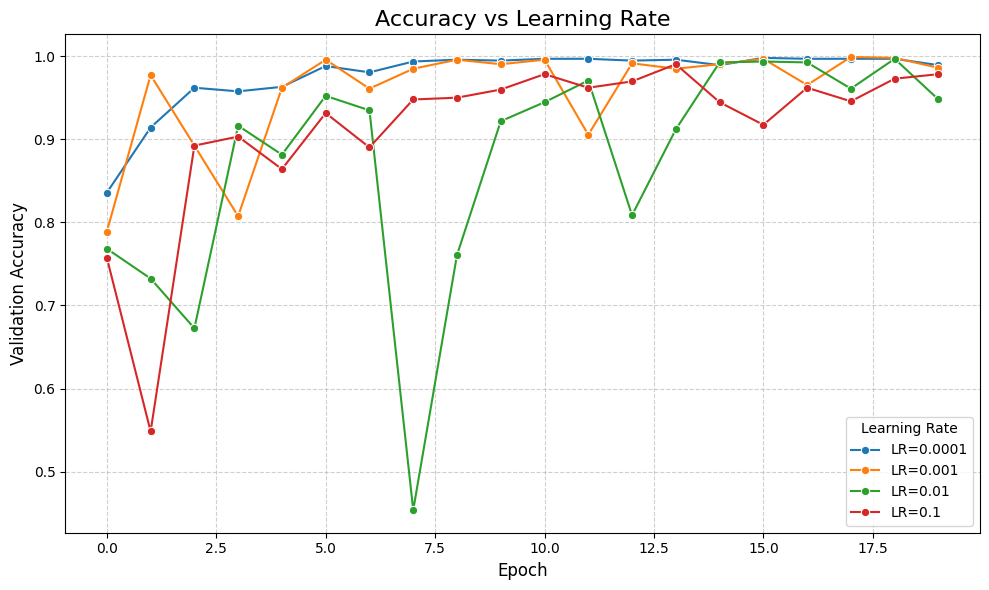

In [27]:
def plot_accuracy_vs_learning_rate(learning_rate_scores):
    all_data = []

    for learning_rate, history in learning_rate_scores.items():
        epochs = np.arange(len(history['val_accuracy']))
        val_accuracy = history['val_accuracy']
        data = pd.DataFrame({
            "Epoch": epochs,
            "Validation Accuracy": val_accuracy,
            "Learning Rate": f"LR={learning_rate}"
        })
        all_data.append(data)

    combined_data = pd.concat(all_data, ignore_index=True)

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_data, x="Epoch", y="Validation Accuracy", hue="Learning Rate", marker="o")

    plt.title("Accuracy vs Learning Rate", fontsize=16)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Validation Accuracy", fontsize=12)
    plt.legend(title="Learning Rate")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_accuracy_vs_learning_rate(learning_rate_scores)

In [29]:
dropout_rate_scores = {}

for dropout_rate in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    print(dropout_rate)

    model = make_model(learning_rate=0.0001, dropout_rate=dropout_rate, size_inner=128)
    history = model.fit(train,
                        verbose=1,
                        epochs=20,
                        validation_data=validation)
    dropout_rate_scores[dropout_rate] = history.history

    print()
    print()

0.0
Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.7659 - loss: 0.4962 - val_accuracy: 0.7758 - val_loss: 0.4977
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9555 - loss: 0.1534 - val_accuracy: 0.9336 - val_loss: 0.2680
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9851 - loss: 0.0744 - val_accuracy: 0.8923 - val_loss: 0.2834
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9915 - loss: 0.0434 - val_accuracy: 0.9946 - val_loss: 0.0995
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.9985 - loss: 0.0266 - val_accuracy: 0.9902 - val_loss: 0.0686
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9987 - loss: 0.0185 - val_accuracy: 0.9946 - val_loss: 0.0330
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9994 - loss: 0.0140 - val_accuracy: 0.9967 - val_loss: 0.0124
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - accuracy: 0.9998 - los

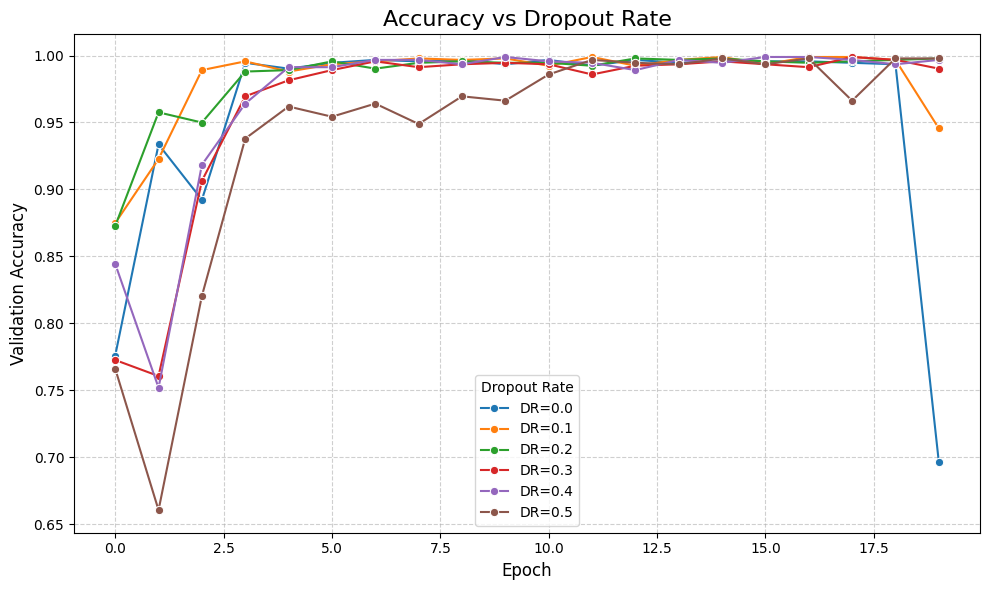

In [ ]:
def plot_accuracy_vs_dropout_rate(dropout_rate_scores):
    all_data = []

    for dropout_rate, history in dropout_rate_scores.items():
        epochs = np.arange(len(history['val_accuracy']))
        val_accuracy = history['val_accuracy']
        data = pd.DataFrame({
            "Epoch": epochs,
            "Validation Accuracy": val_accuracy,
            "Dropout Rate": f"DR={dropout_rate}"
        })
        all_data.append(data)

    combined_data = pd.concat(all_data, ignore_index=True)

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_data, x="Epoch", y="Validation Accuracy", hue="Dropout Rate", marker="o")

    plt.title("Accuracy vs Dropout Rate", fontsize=16)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Validation Accuracy", fontsize=12)
    plt.legend(title="Dropout Rate")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_accuracy_vs_dropout_rate(dropout_rate_scores)

In [31]:
dense_layer_size_scores = {}

for dense_layer_size in [64, 128, 256, 512]:
    print(dense_layer_size)

    model = make_model(learning_rate=0.0001, dropout_rate=0.2, size_inner=dense_layer_size)
    history = model.fit(train,
                        verbose=1,
                        epochs=20,
                        validation_data=validation)
    dense_layer_size_scores[dense_layer_size] = history.history

    print()
    print()

64
Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.7172 - loss: 0.5541 - val_accuracy: 0.8629 - val_loss: 0.4633
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.8984 - loss: 0.2680 - val_accuracy: 0.9608 - val_loss: 0.4009
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.9624 - loss: 0.1686 - val_accuracy: 0.9815 - val_loss: 0.2140
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 120ms/step - accuracy: 0.9759 - loss: 0.1197 - val_accuracy: 0.9391 - val_loss: 0.2207
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.9917 - loss: 0.0789 - val_accuracy: 0.9260 - val_loss: 0.2025
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.9915 - loss: 0.0657 - val_accuracy: 0.9946 - val_loss: 0.0546
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.9887 - loss: 0.0655 - val_accuracy: 0.9815 - val_loss: 0.0805
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 14s 119ms/step - accuracy: 0.9924 - loss

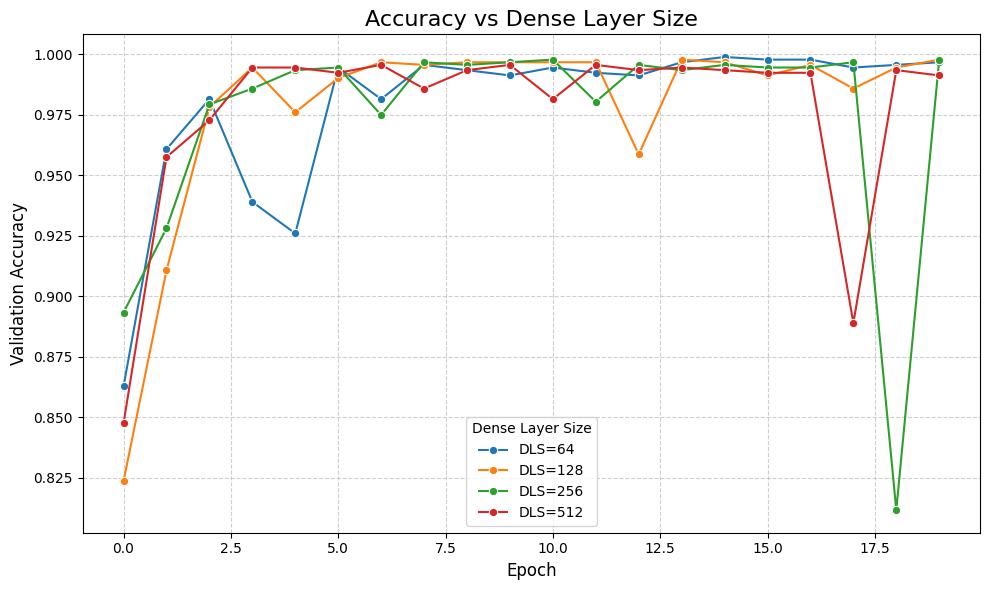

In [32]:
def plot_accuracy_vs_dense_layer_size(dense_layer_size_scores):
    all_data = []

    for dense_layer_size, history in dense_layer_size_scores.items():
        epochs = np.arange(len(history['val_accuracy']))
        val_accuracy = history['val_accuracy']
        data = pd.DataFrame({
            "Epoch": epochs,
            "Validation Accuracy": val_accuracy,
            "Dense Layer Size": f"DLS={dense_layer_size}"
        })
        all_data.append(data)

    combined_data = pd.concat(all_data, ignore_index=True)

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_data, x="Epoch", y="Validation Accuracy", hue="Dense Layer Size", marker="o")

    plt.title("Accuracy vs Dense Layer Size", fontsize=16)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Validation Accuracy", fontsize=12)
    plt.legend(title="Dense Layer Size")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_accuracy_vs_dense_layer_size(dense_layer_size_scores)

# Data Augmentation:

In [34]:
image_data_generator = ImageDataGenerator(
    validation_split = 0.2,
    rescale=1./255,              # Normalize image between 0 and 1
    rotation_range=20,           # Rotate images by up to 20 degrees
    width_shift_range=0.2,       # Horizontal shift up to 20%
    height_shift_range=0.2,      # Vertical shift up to 20%
    shear_range=0.2,             # Shear transformation
    zoom_range=0.2,              # Zoom images
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest'          # Fill pixels that become empty after transformations
)

train = image_data_generator.flow_from_directory(
                               DATA_DIR,
                               target_size = (150, 150),
                               batch_size = 32,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = SEED,
                               subset = "training")


validation = image_data_generator.flow_from_directory(
                               DATA_DIR,
                               target_size = (150, 150),
                               batch_size = 32,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = SEED,
                               subset = "validation")


model = make_model(learning_rate=0.0001, dropout_rate=0.2, size_inner=128)

history = model.fit(train,
                    verbose=1,
                    epochs=20,
                    validation_data=validation)

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.
Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 134ms/step - accuracy: 0.5629 - loss: 0.8072 - val_accuracy: 0.6028 - val_loss: 0.6490
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.6141 - loss: 0.7104 - val_accuracy: 0.5941 - val_loss: 0.7235
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.6683 - loss: 0.6342 - val_accuracy: 0.6017 - val_loss: 0.6899
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.6873 - loss: 0.6191 - val_accuracy: 0.5147 - val_loss: 1.0754
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.7210 - loss: 0.5714 - val_accuracy: 0.6910 - val_loss: 0.5949
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.7378 - loss: 0.5421 - val_accuracy: 0.7106 - val_loss: 0.5604
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - accuracy: 0.7429 - loss: 0.5361 - val_accuracy: 0.7508 - val_loss: 0.5065


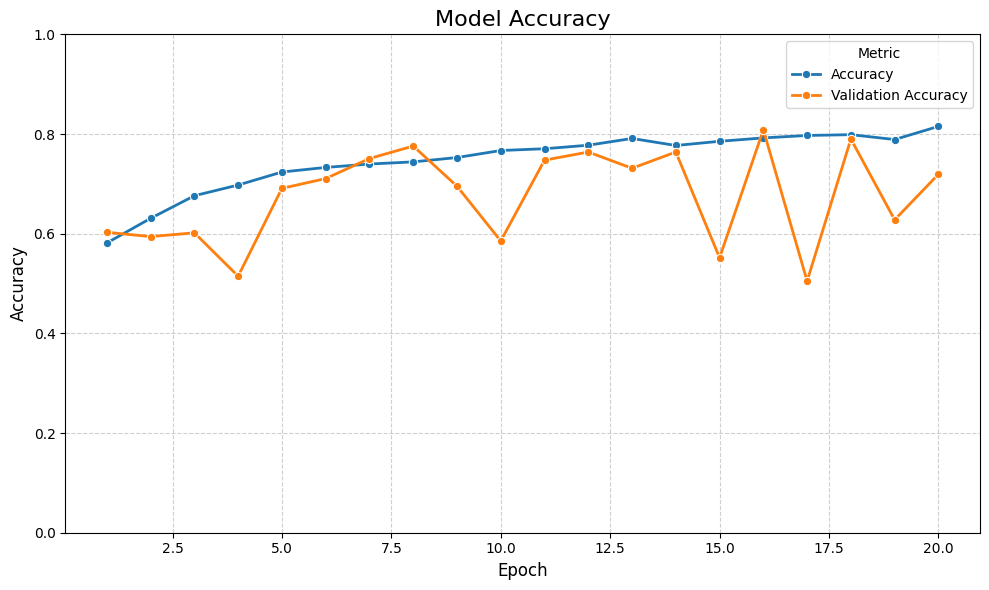

In [35]:
plot_model_accuracy(history)

# Xception Model:

In [36]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input


def make_xception_model(learning_rate=0.0001, size_inner=128, droprate=0.2):

    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False

    #########################################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(10)(drop)

    model = keras.Model(inputs, outputs)

    #########################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )

    return model

In [38]:
image_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          validation_split = 0.2)

train = image_data_generator.flow_from_directory(
                               DATA_DIR,
                               target_size = (150, 150),
                               batch_size = 32,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = SEED,
                               subset = "training")


validation = image_data_generator.flow_from_directory(
                               DATA_DIR,
                               target_size = (150, 150),
                               batch_size = 32,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = SEED,
                               subset = "validation")

xception_model = make_xception_model()
history = xception_model.fit(train, epochs=20, validation_data=validation)

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.
Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 44s 367ms/step - accuracy: 0.6255 - loss: 1.0121 - val_accuracy: 0.8553 - val_loss: 0.3552
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 40s 347ms/step - accuracy: 0.8682 - loss: 0.3387 - val_accuracy: 0.9010 - val_loss: 0.2624
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 40s 346ms/step - accuracy: 0.8951 - loss: 0.2687 - val_accuracy: 0.9173 - val_loss: 0.2201
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 40s 347ms/step - accuracy: 0.9214 - loss: 0.2177 - val_accuracy: 0.9336 - val_loss: 0.1986
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 40s 346ms/step - accuracy: 0.9194 - loss: 0.2000 - val_accuracy: 0.9380 - val_loss: 0.1678
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 40s 346ms/step - accuracy: 0.9436 - loss: 0.1639 - val_accuracy: 0.9489 - val_loss: 0.1501
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 40s 346ms/step - accuracy: 0.9392 - loss: 0.1605 - val_accuracy: 0.9478 - val_loss: 0.1476


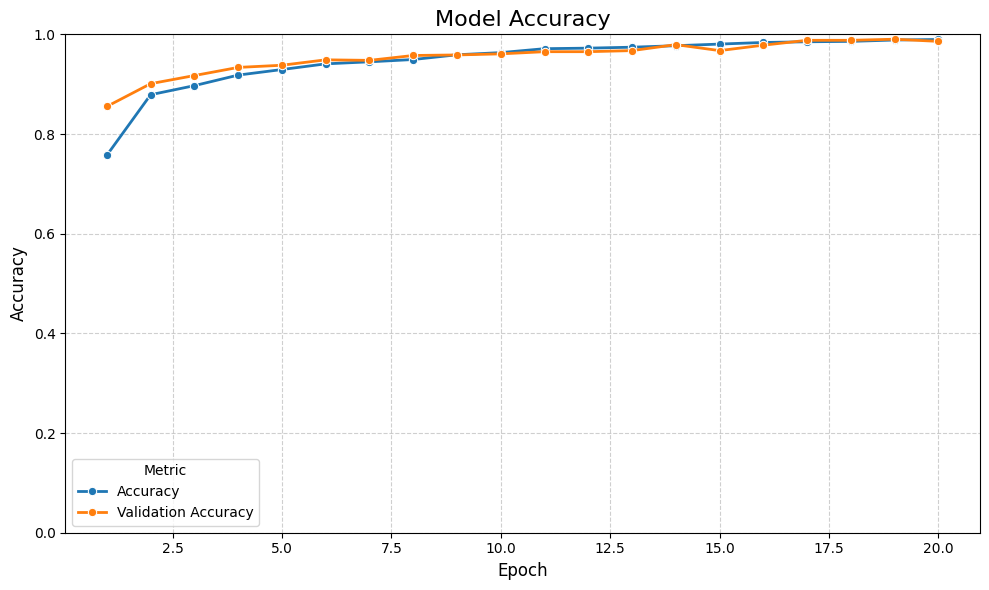

In [39]:
plot_model_accuracy(history)

# Final Training:

In [40]:
image_data_generator = ImageDataGenerator(rescale=1./255,
                                          validation_split = 0.2,
                                          zoom_range=(0.99, 0.99))

train = image_data_generator.flow_from_directory(
                               DATA_DIR,
                               target_size = (150, 150),
                               batch_size = 32,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = SEED,
                               subset = "training")


validation = image_data_generator.flow_from_directory(
                               DATA_DIR,
                               target_size = (150, 150),
                               batch_size = 32,
                               class_mode = "binary",
                               color_mode = "rgb",
                               shuffle = True,
                               seed = SEED,
                               subset = "validation")

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


In [42]:
checkpoint = keras.callbacks.ModelCheckpoint(
    './Trained_Models/Sequential_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

model = make_model(learning_rate=0.0001, dropout_rate=0.2, size_inner=128)

history = model.fit(train,
                    verbose=1,
                    callbacks = [checkpoint],
                    epochs=50,
                    validation_data=validation)

Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.7175 - loss: 0.5902 - val_accuracy: 0.7476 - val_loss: 0.4834
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.9015 - loss: 0.2638 - val_accuracy: 0.7878 - val_loss: 0.5018
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.9636 - loss: 0.1222 - val_accuracy: 0.9684 - val_loss: 0.2291
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.9824 - loss: 0.0753 - val_accuracy: 0.9924 - val_loss: 0.0977
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 0.9920 - loss: 0.0441 - val_accuracy: 0.9880 - val_loss: 0.0874
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.9949 - loss: 0.0333 - val_accuracy: 0.9978 - val_loss: 0.0266
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.9987 - loss: 0.0200 - val_accuracy: 0.9576 - val_loss: 0.1232
Epoch 8/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - accuracy: 0.9960 - loss: 0

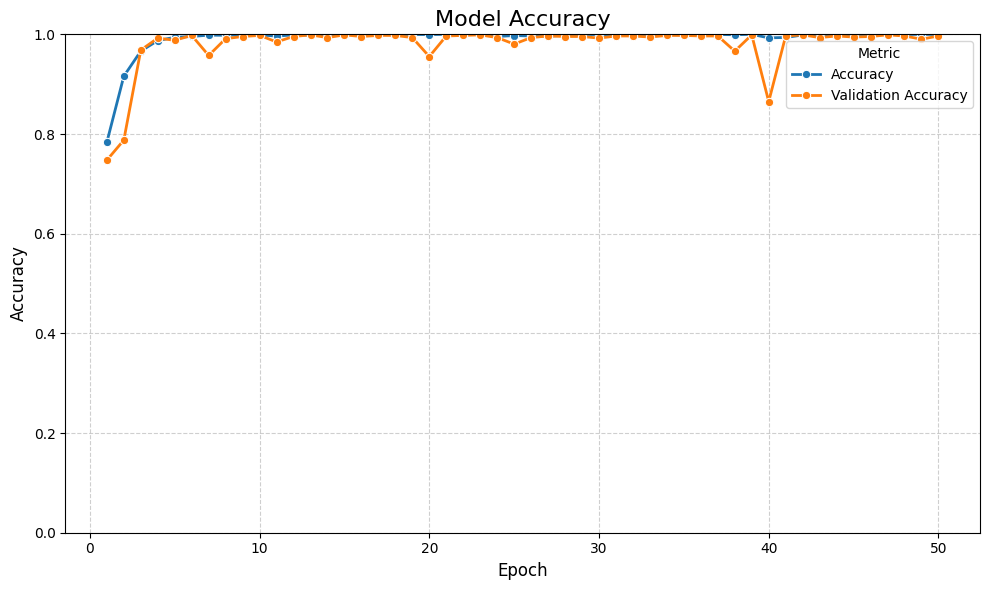

In [43]:
plot_model_accuracy(history)